In [ ]:
# For colab users
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/capstone

/content/drive/My Drive/capstone


In [ ]:
!pip install python-Levenshtein

In [1]:
import model as m

import argparse
import os
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.nn.utils import clip_grad_norm
import torchtext.data as data
import random
import matplotlib.pyplot as plt
from tqdm import notebook
from sklearn.model_selection import KFold

### train function

In [2]:
def train(config, train_iter, model, criterion, optimizer, epoch, dic, save_path, prob=0):
    global iteration, n_total, train_loss, n_bad_loss
    global init, best_val_loss, stop

    print("=> EPOCH {}".format(epoch))
    train_iter.init_epoch()
    for i, batch in notebook.tqdm(enumerate(train_iter), total=len(train_iter)):
        # TODO 
        # add noise to batch
        g = batch.grapheme
        # if random.random() > prob:
         #   g = grapheme_add_noise(0.1, g, dic)
        
        
        iteration += 1
        model.train()
        output, _, __ = model(g, batch.phoneme[:-1].detach())
        target = batch.phoneme[1:]
        # print(output.size())
        loss = criterion(output.view(output.size(0) * output.size(1), -1),
                         target.view(target.size(0) * target.size(1)))
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip, 'inf')
        optimizer.step()
        
        n_total += batch.batch_size
        train_loss += loss.data * batch.batch_size
        
        # print("   % Time: {:5.0f} | Iteration: {:5} | Batch: {:4}/{}"
        #           " | Train loss: {:.4f}"
        #           .format(time.time()-init, iteration, train_iter.iterations,
        #                   len(train_iter), train_loss))
        
        if iteration % config.log_every == 0:
            train_loss /= n_total
            val_loss = validate(val_iter, model, criterion)
            print("   % Time: {:5.0f} | Iteration: {:5} | Batch: {:4}/{}"
                  " | Train loss: {:.4f} | Val loss: {:.4f}"
                  .format(time.time()-init, iteration, train_iter.iterations,
                          len(train_iter), train_loss, val_loss))
            
            # test for val_loss improvement
            n_total = train_loss = 0
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                n_bad_loss = 0
                torch.save(model.state_dict(), save_path)
            else:
                n_bad_loss += 1
            if n_bad_loss == config.n_bad_loss:
                best_val_loss = val_loss
                n_bad_loss = 0
                m.adjust_learning_rate(optimizer, config.lr_decay)
                new_lr = optimizer.param_groups[0]['lr']
                print("=> Adjust learning rate to: {}".format(new_lr))
                if new_lr < config.lr_min:
                    stop = True
                    break

### Validation Function

In [3]:
def validate(val_iter, model, criterion):
    model.eval()
    val_loss = 0
    val_iter.init_epoch()
    for batch in val_iter:
        output, _, __ = model(batch.grapheme, batch.phoneme[:-1])
        target = batch.phoneme[1:]
        loss = criterion(output.squeeze(1), target.squeeze(1))
        val_loss += loss.data * batch.batch_size
    
    return val_loss / len(val_iter.dataset)

### Test Function

In [4]:
def test(test_iter, model, g_dic, p_dic, print_error=False):
    model.eval()
    test_iter.init_epoch()
    test_per = 0
    wrong = []
    with torch.no_grad():
        for batch in test_iter:
            output = model(batch.grapheme).data.tolist()
            target = batch.phoneme[1:].squeeze(1).data.tolist()
            # calculate per, wer here
            try:
                per = m.phoneme_error_rate(output[:output.index(3) + 1], target)
            except ValueError:
                per = m.phoneme_error_rate(output, target) 

            if per > 0:
                
                tmp = list([g_dic[g] for g in batch.grapheme])
                tmp.reverse()
                wrong.append(tmp)

                if print_error:        
                    print("Grapheme: {}\nTarget: {}\nPrediction: {}\n".format(
                      ''.join(tmp),
                      ' '.join([p_dic[p] for p in target]),
                      ' '.join([p_dic[p] for p in output])))

            test_per += per  # batch_size = 1
        
        test_per = test_per / len(test_iter.dataset) * 100
        print("Phoneme error rate (PER): {:.2f}\n"
              .format(test_per))
    
    return test_per, wrong

In [5]:
def print_result(model, lines, grapheme, g_dic, p_dic):
    g = grapheme[:-3]
    for line in lines:
        if line.strip().split()[0] == g:
            target = line.strip().split()[1:]

    input = [2]
    for letter in g:
        input.insert(1, g_dic.index(letter))
    input = torch.unsqueeze(torch.LongTensor(input).to("cuda"), 1)
    
    with torch.no_grad():

        output = model(input).data.tolist()

     
    print("Grapheme: {}\nTarget: {}\nPrediction: {}\n".format(
            g, ' '.join(target), ' '.join([p_dic[p] for p in output[:-1]]) ) )

## Set parameter

In [6]:
parser = {
    'num_row': -1, # modify num_row to -1 if you want to input all data points
    'epochs': 15,
    'batch_size': 128,
    'max_len': 20,  # max length of grapheme/phoneme sequences
    'beam_size': 5,  # size of beam for beam-search
    'd_embed': 30,  # embedding dimension
    'd_hidden': 32,  # hidden dimension
    'attention': True,  # use attention or not
    'log_every': 100,  # number of iterations to log and validate training
    'lr': 0.007,  # initial learning rate
    'lr_decay': 0.5,  # decay lr when not observing improvement in val_loss
    'lr_min': 5e-4,  # stop when lr is too low
    'n_bad_loss': 5,  # number of bad val_loss before decaying
    'clip': 2.3,  # clip gradient, to avoid exploding gradient
    'cuda': True,  # using gpu or not
    'seed': 1234,  # initial seed
}
args = argparse.Namespace(**parser)

In [7]:
args.cuda = args.cuda and torch.cuda.is_available()

# if not os.path.isdir(args.intermediate_path):
#     os.makedirs(args.intermediate_path)
# if not os.path.isdir(args.data_path):
#     os.makedirs(args.data_path)
#     URL = "https://github.com/cmusphinx/cmudict/archive/master.zip"
#     !wget $URL -O ./data/cmudict.zip
#     !unzip ./data/cmudict.zip -d ./data/
#     !mv ./data/cmudict-master $args.data_path

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

## split the data and build dataloader

In [8]:
import pandas as pd
import pickle
from sklearn import model_selection

In [9]:
df = pd.read_csv("../filtered_no_stress_freq.csv", index_col=0)

In [10]:
df.head()

,word,frequency
0,'bout B AW T\n,1
1,'em AH M\n,41
2,'round R AW N D\n,5
3,'tis T IH Z\n,2
4,a AH\n,23195


In [11]:
re = pd.read_excel("../Reg_Irregular Words.xlsx")

In [12]:
reg_list = re.iloc[:100,:]["Regular"].tolist()
irreg_list = re.iloc[:100,:]["Irregular"].tolist()

In [13]:
len(df)

34014

In [14]:
words = []
freq = []
drop = []
for i, rows in enumerate(df["word"]):
    if rows.strip().split()[0] in reg_list or rows.strip().split()[0] in irreg_list:
        words.append(rows)
        freq.append(df.iloc[i,1])
        drop.append(i)

In [15]:
new_df = df.drop(drop)

In [16]:
len(new_df) + len(drop)

34014

In [17]:
test_df = pd.DataFrame({"word":words, "frequency": freq})

In [18]:
test_df

,word,frequency
0,above AH B AH V\n,296
1,across AH K R AO S\n,282
2,after AE F T ER\n,1069
3,airplane EH R P L EY N\n,11
4,amount AH M AW N T\n,172
...,...,...
194,wool W UH L\n,10
195,word W ER D\n,274
196,work W ER K\n,762
197,worm W ER M\n,4


In [19]:
kf = KFold(n_splits=10)

In [20]:
new_df = new_df.sample(frac=1, random_state=777)
kf.get_n_splits(new_df)

10

In [21]:
new_df.head(), new_df.shape

(                                    word  frequency
 4973           chandler CH AE N D L ER\n         32
 17573                 lewis' L UW IH S\n          1
 12029  forefathers F AO R F AA DH ER Z\n          1
 32660                      vies V AY Z\n          1
 26154                  rumor R UW M ER\n          8,
 (33815, 2))

In [22]:
# please rerun this line if you need to retrain the model!!!
cv_generator = kf.split(new_df)

In [ ]:
e = 1
test_pers = []
reg_per = []
irreg_per = []
for train_index, test_index in cv_generator:
    # data preparation
    print("data preparation for split " + str(e))
    train_set = new_df.iloc[train_index,]
    val_set = new_df.iloc[test_index,]
    test_set = test_df
    weight = np.clip(train_set["frequency"].tolist(), 0, 1000)
    np.random.seed(args.seed)
    train_lines = np.random.choice(train_set["word"].tolist(), size=100000, p=(np.array(weight) / sum(weight)) )
    val_lines = val_set["word"].tolist()
    test_lines = test_set["word"].tolist()
    train_iter, val_iter, test_iter, g_field, p_field = m.prepare_data(train_lines, val_lines, test_lines, args)
    dic = g_field.vocab.itos

    # Training
    #set up configuration
    print("Training for epoch " + str(e))
    config = args
    config.g_size = len(g_field.vocab)
    config.p_size = len(p_field.vocab)
    config.d_hidden = 32
    save_path = "../model_para/reg_vs_irreg/cv_" + str(config.d_hidden) + "/best_model_" + str(config.d_hidden) + "_fold_" + str(e) + ".pt"
    
    model = m.G2P(config)
    criterion = nn.NLLLoss()
    if config.cuda:
        model.cuda()
        criterion.cuda()
    optimizer = optim.Adam(model.parameters(), lr=config.lr)  # use Adagrad
    
    # training
    iteration = n_total = train_loss = n_bad_loss = 0
    stop = False
    best_val_loss = 10
    init = time.time()

    # If you want to change epoch, uncomment the following line
    # config.epochs = 10

    for epoch in range(1, config.epochs+1):
        train(config, train_iter, model, criterion, optimizer, epoch, dic, save_path)
        if stop:
            break

    #calculate result
    #regular and irregular word performance
    re_predictions = {}
    with torch.no_grad():
        for w in reg_list:
            embed = [2]
            for letter in w:
                embed.insert(1, g_field.vocab.itos.index(letter))
            embed = torch.unsqueeze(torch.LongTensor(embed), 1).to('cuda')
            prediction = model0(embed).data.tolist()
            re_predictions[word] = [p_field.vocab.itos[p] for p in prediction]

    irre_predictions = {}
    with torch.no_grad():
        for w in irreg_list:
            w = w.lower()
            embed = [2]
            for letter in word:
                embed.insert(1, g_field.vocab.itos.index(letter))
            embed = torch.unsqueeze(torch.LongTensor(embed), 1).to('cuda')
            prediction = model0(embed).data.tolist()
            irre_predictions[word] = [p_field.vocab.itos[p] for p in prediction]

    #build answer sheet
    answer_sheet = {}
    for line in df["word"]:
        tmp = line.strip().split()
        phoneme = tmp[1:]
        phoneme.append('</os>')
        answer_sheet[tmp[0]] = phoneme

    n = 0
    test_per_re = []
    for key, value in enumerate(re_predictions):
        try:
            pred = re_predictions[value]
            per = m.phoneme_error_rate(pred[:pred.index("</os>") + 1], answer_sheet[value])

            test_per_re.append(per)
            n += 1
        except KeyError:
            continue

    reg_per.append(sum(test_per_re) / n * 100)
    print("PER for regular word for the split " + str(e) + " is " + str(reg_per))

    n = 0
    test_per_ir = []
    for key, value in enumerate(irre_predictions):
        try:
            per = m.phoneme_error_rate(irre_predictions[value], answer_sheet[value])
            test_per_ir.append(per)
            n += 1
        except KeyError:
            continue

    irreg_per.append(sum(test_per_ir) / n * 100)
    print("PER for irregular word for the split " + str(e) + " is " + str(irreg_per))

    e += 1

data preparation for split 1


C:\Users\limu\anaconda3\lib\site-packages\torchtext\data\field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
C:\Users\limu\anaconda3\lib\site-packages\torchtext\data\example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
C:\Users\limu\anaconda3\lib\site-packages\torchtext\data\iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further in

Training for epoch 1


Text(0, 0.5, 'PER')

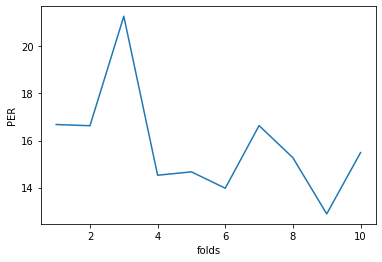

In [ ]:
plt.plot(np.arange(1,11), test_pers)
plt.xlabel("folds")
plt.ylabel("PER")

In [ ]:
test_pers

[16.680256771811873,
 16.630432365661633,
 21.278982138770576,
 14.527798147662663,
 14.670658797840163,
 13.975804435840262,
 16.63578164940222,
 15.270198536149643,
 12.884835015739338,
 15.488006724256383]

In [ ]:
np.mean(test_pers)

15.804275458313475

In [ ]:
np.std(test_pers)

2.1743936668924224

In [ ]:
np.mean(test_pers) + np.std(test_pers)

17.978669125205897